## Persistence Landscapes

- vectorized representations of persistence diagrams

- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region
- difference landscapes

Author: @emilyekstrum
<br> 11/26/25

In [39]:
# import modules
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim import persistent_entropy
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
from persim.landscapes import plot_landscape
import random
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any
from sklearn.decomposition import PCA
from ripser import ripser
from persim import wasserstein
from sklearn.neighbors import NearestNeighbors    
from scipy.sparse import coo_matrix    

In [40]:
# import TDA utilities
import sys
from pathlib import Path

repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# summary of available data
data_manager.print_summary()

TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


# for plots
- x axis = filtration parameter (midpoint of feature (death - birth)/2)
- y axis = "feature persistence strength" (half-life of feature (birth+death)/2)

In [41]:
# set primary data directory based on available files
all_persistence_files = data_manager.find_files("*.pkl", "persistence_examples")

if all_persistence_files:
    # use the directory of the first file as primary, but search all
    data_dir = all_persistence_files[0].parent
    print(f"Primary data directory: {data_dir}")
    print(f"Total persistence files available: {len(all_persistence_files)}")
    
    # check if there are files from all_dgms (more comprehensive dataset)
    all_dgms_files = [f for f in all_persistence_files if 'all_dgms' in str(f)]
    if all_dgms_files:
        print(f"Files from all_dgms.zip: {len(all_dgms_files)}")
    
    # check persistence_examples files
    examples_files = [f for f in all_persistence_files if 'persistence_diagram_examples' in str(f)]
    if examples_files:
        print(f"Files from persistence_examples: {len(examples_files)}")
        
else:
    # use original directory
    data_dir = data_manager.data_paths['persistence_examples']
    print(f"Getting dgms files from: {data_dir}")

# stimulus mapping 
stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "cex": "color_exchange",
    "lf": "luminance_flash",
    "ng": "natural_gratings",
    "nm": "natural_movie",
    "rf": "receptive_field",
    "sp": "sparse_noise"
}

def parse_filename(fname: str):
    """ Enhanced filename parser for comprehensive dataset support.
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    # TDA utils for parsing
    info = data_manager.parse_filename_info(fname)
    
    return {
        "method": "CEBRA",  
        "embed_dim": info['dimension'],
        "region": info['region'],
        "stim": info['stimulus'],
        "mouse": info['mouse_id'],
    }

def load_dgms(path):
    """ Enhanced diagram loader that works with all file sources.
    
    Args:
        path (str or Path): path to pickle file (can be relative name or full path)
    Returns:
        list: diagrams"""

    # handle full paths and filenames
    if isinstance(path, str) and not path.startswith('/'):
        # find the full path of file name
        matching_files = [f for f in all_persistence_files if f.name == path]
        if matching_files:
            path = matching_files[0]
        else:
            # try in the primary data directory
            path = data_dir / path
    
    return data_manager.load_persistence_diagrams(path)

Primary data directory: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples
Total persistence files available: 22
Files from persistence_examples: 22


In [42]:
# load all available persistence diagram files from multiple sources
available_files = data_manager.find_files("*.pkl", "persistence_examples")

if available_files:
    
    # organize by region, stimulus, and dimension 
    file_organization = {}
    dimension_counts = {}
    stimulus_counts = {}
    
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        region = info['region']
        stimulus = info['stimulus']
        dimension = info['dimension']
        
        # count by categories
        key = f"{region}_{stimulus}"
        if key not in file_organization:
            file_organization[key] = []
        file_organization[key].append(file_path)
        
        # track dimensions and stimuli
        dimension_counts[dimension] = dimension_counts.get(dimension, 0) + 1
        stimulus_counts[stimulus] = stimulus_counts.get(stimulus, 0) + 1
    
    print(f"\nAvailable data combinations:")
    for combo, files in sorted(file_organization.items()):
        region, stim = combo.split('_', 1)
        dimensions_in_combo = sorted(set(data_manager.parse_filename_info(f)['dimension'] for f in files),
                                   key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
        print(f"  • {region} - {stim.replace('_', ' ').title()}: {len(files)} files ({', '.join(dimensions_in_combo)})")
        
    # separate lists for each region (maintaining backward compatibility)
    LGN_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'LGN']
    V1_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'V1']
    
    print(f"\nCompatibility lists:")
    print(f"   LGN files: {len(LGN_files)}")
    print(f"   V1 files: {len(V1_files)}")
    
else:
    print("No persistence diagram files found.")
    print("Error checklist:")
    print("  1. Run the Ripser notebook (02_Ripser.ipynb) to generate persistence diagrams")
    print("  2. Put all_dgms.zip in the data/ directory")
    print("  3. Add .pkl files directly to data/persistence_diagram_examples/")
    LGN_files = []
    V1_files = []


Available data combinations:
  • LGN - Color Exchange: 8 files (3d, 8d, 24d, 32d)
  • V1 - Color Exchange: 14 files (3d, 8d, 24d, 32d)

Compatibility lists:
   LGN files: 8
   V1 files: 14


## Average PLs by region

In [48]:
# average landscapes for each homology group (H0, H1, H2) - WITH DEBUGGING
if available_files:
    
    avg_lgn_landscapes = {}
    avg_v1_landscapes = {}

    print(f"🔍 Starting landscape computation with {len(LGN_files)} LGN files and {len(V1_files)} V1 files")
    print(f"📂 Data directory: {data_dir}")
    
    for hom_deg in range(3): 
        print(f"\n  Processing H{hom_deg}")
        LGN_landscape = []
        V1_landscape = []
        
        # LGN files - with detailed debugging
        lgn_count = 0
        lgn_errors = 0
        lgn_empty = 0
        
        for f in LGN_files:
            try:
                fpath = data_dir / f
                print(f"    📁 Loading LGN file: {f}")
                
                if not fpath.exists():
                    print(f"      ❌ File not found: {fpath}")
                    continue
                    
                dgms = load_dgms(fpath)
                print(f"      📊 Loaded diagrams: {type(dgms)}, length: {len(dgms) if dgms else 0}")
                
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                    
                if dgms and len(dgms) > hom_deg:
                    current_dgm = dgms[hom_deg]
                    print(f"      🔬 H{hom_deg} diagram: {type(current_dgm)}, size: {len(current_dgm) if current_dgm is not None else 0}")
                    
                    if current_dgm is not None and len(current_dgm) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        LGN_landscape.append(persistence_landscape)
                        lgn_count += 1
                        print(f"      ✅ Landscape created successfully")
                    else:
                        lgn_empty += 1
                        print(f"      ⚠️ Empty H{hom_deg} diagram")
                else:
                    lgn_empty += 1
                    print(f"      ⚠️ Insufficient homology degrees or empty diagrams")
                    
            except Exception as e:
                lgn_errors += 1
                print(f"      ❌ Error processing {f}: {e}")
                continue
        
        print(f"    📊 LGN H{hom_deg} summary: {lgn_count} landscapes, {lgn_empty} empty, {lgn_errors} errors")
        
        # V1 files - with detailed debugging
        v1_count = 0
        v1_errors = 0
        v1_empty = 0
        
        for f in V1_files:
            try:
                fpath = data_dir / f
                print(f"    📁 Loading V1 file: {f}")
                
                if not fpath.exists():
                    print(f"      ❌ File not found: {fpath}")
                    continue
                    
                dgms = load_dgms(fpath)
                print(f"      📊 Loaded diagrams: {type(dgms)}, length: {len(dgms) if dgms else 0}")
                
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                    
                if dgms and len(dgms) > hom_deg:
                    current_dgm = dgms[hom_deg]
                    print(f"      🔬 H{hom_deg} diagram: {type(current_dgm)}, size: {len(current_dgm) if current_dgm is not None else 0}")
                    
                    if current_dgm is not None and len(current_dgm) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        V1_landscape.append(persistence_landscape)
                        v1_count += 1
                        print(f"      ✅ Landscape created successfully")
                    else:
                        v1_empty += 1
                        print(f"      ⚠️ Empty H{hom_deg} diagram")
                else:
                    v1_empty += 1
                    print(f"      ⚠️ Insufficient homology degrees or empty diagrams")
                    
            except Exception as e:
                v1_errors += 1
                print(f"      ❌ Error processing {f}: {e}")
                continue
        
        print(f"    📊 V1 H{hom_deg} summary: {v1_count} landscapes, {v1_empty} empty, {v1_errors} errors")
        
        # average persistence landscapes 
        if LGN_landscape:
            try:
                avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscape)
                print(f"    ✅ LGN H{hom_deg}: {lgn_count} landscapes averaged successfully")
            except Exception as e:
                print(f"    ❌ LGN H{hom_deg}: Failed to average landscapes - {e}")
                
        if V1_landscape:
            try:
                avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscape)
                print(f"    ✅ V1 H{hom_deg}: {v1_count} landscapes averaged successfully")
            except Exception as e:
                print(f"    ❌ V1 H{hom_deg}: Failed to average landscapes - {e}")
    
    print(f"\n🏁 Landscape computation complete!")
    print(f"📈 LGN landscapes created: {list(avg_lgn_landscapes.keys())}")
    print(f"📈 V1 landscapes created: {list(avg_v1_landscapes.keys())}")
    
    # save individual landscape variables
    avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
    avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
    avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
    avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
    avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
    avg_v1_h2_landscape = avg_v1_landscapes.get('H2')
    
    # Test one landscape to see its structure
    if avg_lgn_landscapes:
        test_landscape = next(iter(avg_lgn_landscapes.values()))
        if test_landscape:
            print(f"\n🔬 Sample landscape structure:")
            print(f"   Type: {type(test_landscape)}")
            print(f"   Has landscapes attr: {hasattr(test_landscape, 'landscapes')}")
            if hasattr(test_landscape, 'landscapes'):
                print(f"   Number of layers: {len(test_landscape.landscapes)}")
                print(f"   Layer 0 size: {len(test_landscape.landscapes[0]) if test_landscape.landscapes else 0}")
    
else:
    print("No files available for landscape computation.")

🔍 Starting landscape computation with 8 LGN files and 14 V1 files
📂 Data directory: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples

  Processing H0
    📁 Loading LGN file: CEBRA_32d_LGN_cex_C153.pkl
      📊 Loaded diagrams: <class 'list'>, length: 3
      🔬 H0 diagram: <class 'numpy.ndarray'>, size: 10000
      ✅ Landscape created successfully
    📁 Loading LGN file: CEBRA_3d_LGN_cex_C153.pkl
      📊 Loaded diagrams: <class 'list'>, length: 3
      🔬 H0 diagram: <class 'numpy.ndarray'>, size: 10000
      ✅ Landscape created successfully
    📁 Loading LGN file: CEBRA_8d_LGN_cex_C159.pkl
      📊 Loaded diagrams: <class 'list'>, length: 3
      🔬 H0 diagram: <class 'numpy.ndarray'>, size: 5000
      ✅ Landscape created successfully
    📁 Loading LGN file: CEBRA_24d_LGN_cex_C159.pkl
      📊 Loaded diagrams: <class 'list'>, length: 3
      🔬 H0 diagram: <class 'numpy.ndarray'>, size: 10000
      ✅ Landscape created successfully
    📁 Loading LGN file: CEBRA_24d_LGN_cex_C153

## Persistence Landscape Plotting System


In [52]:
# RUN ME

# landscape plotting class

class LandscapePlotter:
    """system for creating persistence landscape plots"""
    
    def __init__(self, data_manager, available_files):
        self.data_manager = data_manager
        self.available_files = available_files
        
        # default styling
        self.region_styles = {
            'LGN': {'color': 'tab:blue', 'marker': 'o'},
            'V1': {'color': 'tab:orange', 'marker': 's'}
        }
        
        # stimulus display names
        self.stim_display_names = {
            'color_exchange': 'Color Exchange',
            'luminance_flash': 'Luminance Flash',
            'drifting_gratings': 'Drifting Gratings',
            'chromatic_gratings': 'Chromatic Gratings',
        }
    
    def _get_available_data(self):
        """Get all available stimuli, regions, and dimensions"""
        all_stimuli = sorted(set(self.data_manager.parse_filename_info(f)['stimulus'] for f in self.available_files))
        all_regions = sorted(set(self.data_manager.parse_filename_info(f)['region'] for f in self.available_files))
        all_dimensions = sorted(set(self.data_manager.parse_filename_info(f)['dimension'] for f in self.available_files),
                               key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
        
        # filter out unknowns
        all_stimuli = [s for s in all_stimuli if s != 'unknown']
        all_regions = [r for r in all_regions if r != 'unknown']
        all_dimensions = [d for d in all_dimensions if d != 'unknown']
        
        return all_stimuli, all_regions, all_dimensions
    
    def _compute_landscapes_for_combination(self, hom_deg, stimuli=None, regions=None, dimensions=None):
        """Compute average landscapes for stimulus-region-dimension combinations"""

        all_stimuli, all_regions, all_dimensions = self._get_available_data()
        
        # use stimuluss, regions, dimensions or defaults
        use_stimuli = stimuli if stimuli else all_stimuli
        use_regions = regions if regions else all_regions
        use_dimensions = dimensions if dimensions else all_dimensions
        
        landscape_data = {}
        
        for stimulus in use_stimuli:
            landscape_data[stimulus] = {}
            for region in use_regions:
                landscape_data[stimulus][region] = {}
                for dimension in use_dimensions:
                    # find matching files
                    matching_files = [
                        f for f in self.available_files
                        if (self.data_manager.parse_filename_info(f)['stimulus'] == stimulus and
                            self.data_manager.parse_filename_info(f)['region'] == region and
                            self.data_manager.parse_filename_info(f)['dimension'] == dimension)
                    ]
                    
                    if matching_files:
                        landscapes = []
                        for file_path in matching_files:
                            try:
                                dgms = load_dgms(file_path)
                                if isinstance(dgms, np.ndarray):
                                    dgms = dgms.tolist()
                                
                                if (dgms and len(dgms) > hom_deg and
                                    dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0):
                                    landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                                    landscapes.append(landscape)
                            except Exception:
                                continue
                        
                        if landscapes:
                            try:
                                landscape_data[stimulus][region][dimension] = average_approx(landscapes)
                            except Exception:
                                landscape_data[stimulus][region][dimension] = None
                        else:
                            landscape_data[stimulus][region][dimension] = None
                    else:
                        landscape_data[stimulus][region][dimension] = None
        
        return landscape_data
    
    def _calculate_axis_limits(self, landscape_data):
        """Calculate consistent axis limits across all landscapes"""

        all_x_values, all_y_values = [], []
        
        def extract_from_landscape(landscape):
            if landscape is None:
                return
            try:
                if hasattr(landscape, 'grid'):
                    xs = landscape.grid
                else:
                    xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
                
                if hasattr(landscape, 'landscapes'):
                    landscapes_layers = landscape.landscapes
                else:
                    landscapes_layers = landscape.Ls
                
                all_x_values.extend(xs)
                for layer in landscapes_layers[:3]:  # eirst 3 layers
                    if len(layer) > 0:
                        all_y_values.extend(layer)
            except Exception:
                pass
        
        # extract from nested structure
        for stimulus_data in landscape_data.values():
            if isinstance(stimulus_data, dict):
                for region_data in stimulus_data.values():
                    if isinstance(region_data, dict):
                        # multi-level (stimulus->region->dimension)
                        for landscape in region_data.values():
                            extract_from_landscape(landscape)
                    else:
                        # two-level (stimulus->region or region->homology)
                        extract_from_landscape(region_data)
            else:
                # single level
                extract_from_landscape(stimulus_data)
        
        if all_x_values and all_y_values:
            x_min, x_max = min(all_x_values), max(all_x_values)
            y_min, y_max = max(0, min(all_y_values)), max(all_y_values)
            x_padding = (x_max - x_min) * 0.05
            y_padding = (y_max - y_min) * 0.05
            return (x_min - x_padding, x_max + x_padding), (y_min - y_padding, y_max + y_padding)
        else:
            return (0, 0.3), (0, 0.05)
    
    def _plot_single_landscape(self, ax, landscape, x_limits, y_limits):
        """Plot a single landscape on given axes."""

        if landscape is not None:
            try:
                plt.sca(ax)
                plot_landscape_simple(landscape, title="", 
                                    depth_range=range(min(10, len(landscape.landscapes))))
                
                # remove legends
                legend = ax.get_legend()
                if legend:
                    legend.remove()
            except Exception:
                ax.text(0.5, 0.5, 'Error\nPlotting', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No Data\nAvailable', ha='center', va='center',
                   transform=ax.transAxes, fontsize=12, alpha=0.7)
        
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', labelsize=10)
    
    def _add_global_legend(self, fig, sample_landscape=None):
        """Add a global legend for landscape layers."""

        if sample_landscape:
            n_layers = min(10, len(sample_landscape.landscapes)) if hasattr(sample_landscape, 'landscapes') else 3
        else:
            n_layers = 3
        
        colors = [plt.cm.viridis(i/(n_layers-1)) for i in range(n_layers)]
        handles = [Line2D([0], [0], color=colors[i], linewidth=2) for i in range(n_layers)]
        labels = [f'λ{i}' for i in range(n_layers)]
        
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.02, 0.5),
                  title='Landscape\nLayer', fontsize=11, title_fontsize=12)
    
    def plot_by_region_and_homology(self, landscapes_dict=None, title="Persistence Landscapes by Region",
                                    figsize=(18, 10), save_path=None):
        """Create region x homology grid plot (LGN/V1 vs H0/H1/H2)."""

        if landscapes_dict is None:
            print("No landscape data provided")
            return None
        
        regions = list(landscapes_dict.keys())
        homology_groups = ['H0', 'H1', 'H2']
        
        fig, axes = plt.subplots(len(regions), len(homology_groups), figsize=figsize)
        if len(regions) == 1:
            axes = axes.reshape(1, -1)
        
        x_limits, y_limits = self._calculate_axis_limits(landscapes_dict)
        
        for row_idx, region in enumerate(regions):
            for col_idx, group in enumerate(homology_groups):
                ax = axes[row_idx, col_idx]
                landscape = landscapes_dict[region].get(group)
                self._plot_single_landscape(ax, landscape, x_limits, y_limits)
                
                # labels
                if row_idx == 0:
                    ax.set_title(group, fontsize=18, fontweight='bold')
                if col_idx == 0:
                    ax.set_ylabel(f"$\\mathbf{{{region}}}$\nFeature Persistence",
                                 fontsize=16, fontweight='bold')
                if row_idx == len(regions) - 1:
                    ax.set_xlabel("Filtration Parameter", fontsize=14)
        
        # global legend and title
        sample_landscape = next((landscapes_dict[r].get('H0') or landscapes_dict[r].get('H1') or landscapes_dict[r].get('H2')
                               for r in regions if any(landscapes_dict[r].values())), None)
        self._add_global_legend(fig, sample_landscape)
        
        fig.suptitle(title, fontsize=20, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0, 0.95, 0.96])
        
        if save_path:
            try:
                output_path = self.data_manager.get_output_path(save_path, "analysis_results")
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                print(f"Plot saved to: {output_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")
        
        return fig
    
    def plot_multi_stimulus_grid(self, hom_deg=0, stimuli=None, regions=None, figsize=(20, 10), save_plots=True):
        """Create regions x stimuli grid plot for a specific homology degree."""

        all_stimuli, all_regions, _ = self._get_available_data()
        
        use_stimuli = stimuli if stimuli else all_stimuli
        use_regions = regions if regions else all_regions
        
        if not use_stimuli or not use_regions:
            print(f"No valid stimuli or regions found")
            return None
        
        # compute landscapes
        landscape_data = self._compute_landscapes_for_combination(hom_deg, use_stimuli, use_regions)
        
        # flatten for plotting (stimulus->region structure)
        plot_data = {}
        for stimulus in use_stimuli:
            plot_data[stimulus] = {}
            for region in use_regions:
                # use first available dimension or aggregate all
                region_landscapes = []
                for dim_landscape in landscape_data[stimulus][region].values():
                    if dim_landscape is not None:
                        region_landscapes.append(dim_landscape)
                
                if region_landscapes:
                    try:
                        plot_data[stimulus][region] = average_approx(region_landscapes)
                    except:
                        plot_data[stimulus][region] = region_landscapes[0] if region_landscapes else None
                else:
                    plot_data[stimulus][region] = None
        
        # plot
        n_stimuli = len(use_stimuli)
        n_regions = len(use_regions)
        
        fig, axes = plt.subplots(n_regions, n_stimuli, figsize=figsize, sharey=True, sharex=True)
        
        # handle layout variations
        if n_regions == 1 and n_stimuli == 1:
            axes = [[axes]]
        elif n_regions == 1:
            axes = [axes]
        elif n_stimuli == 1:
            axes = [[ax] for ax in axes]
        
        x_limits, y_limits = self._calculate_axis_limits(plot_data)
        
        for row_idx, region in enumerate(use_regions):
            for col_idx, stimulus in enumerate(use_stimuli):
                ax = axes[row_idx][col_idx]
                landscape = plot_data[stimulus][region]
                self._plot_single_landscape(ax, landscape, x_limits, y_limits)
                
                # labels
                if row_idx == 0:
                    display_name = self.stim_display_names.get(stimulus, stimulus.replace('_', ' ').title())
                    ax.set_title(display_name, fontsize=14, fontweight='bold')
                if col_idx == 0:
                    ax.set_ylabel(f'{region}\nFeature Persistence', fontsize=12, fontweight='bold')
                if row_idx == n_regions - 1:
                    ax.set_xlabel('Filtration Parameter', fontsize=11)
        
        # global legend and title
        sample_landscape = next((plot_data[s][r] for s in use_stimuli for r in use_regions
                               if plot_data[s][r] is not None), None)
        self._add_global_legend(fig, sample_landscape)
        
        fig.suptitle(f'Average Persistence Landscapes by Region and Stimulus for H{hom_deg}',
                    fontsize=16, fontweight='bold', y=0.98)
        
        plt.tight_layout(rect=[0, 0, 0.95, 0.95])
        
        if save_plots:
            try:
                filename = f'multi_stimulus_landscapes_H{hom_deg}.png'
                output_path = self.data_manager.get_output_path(filename, 'analysis_results')
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                print(f"Plot saved to: {output_path}")
            except Exception as e:
                print(f"Error saving plot: {e}")
        
        return fig


# initialize the plotter
if available_files:
    plotter = LandscapePlotter(data_manager, available_files)
else:
    plotter = None
    print(" No data available for plotting")

## Plots

🚀 Starting plot execution...
✅ 22 files available for plotting
✅ Landscape variables found in global scope

PLOT 1: BRAIN REGION COMPARISON
🎨 Starting plot_landscapes_by_region...
✅ Plotter available: True
✅ Available files: 22
✅ Found landscape variables:
   LGN landscapes: ['H0', 'H1', 'H2']
   V1 landscapes: ['H0', 'H1', 'H2']
   Total non-null landscapes: 6
🖼️ Calling plotter.plot_by_region_and_homology...
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/landscapes_by_region.png
✅ Plot created successfully!
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/landscapes_by_region.png
✅ Plot created successfully!


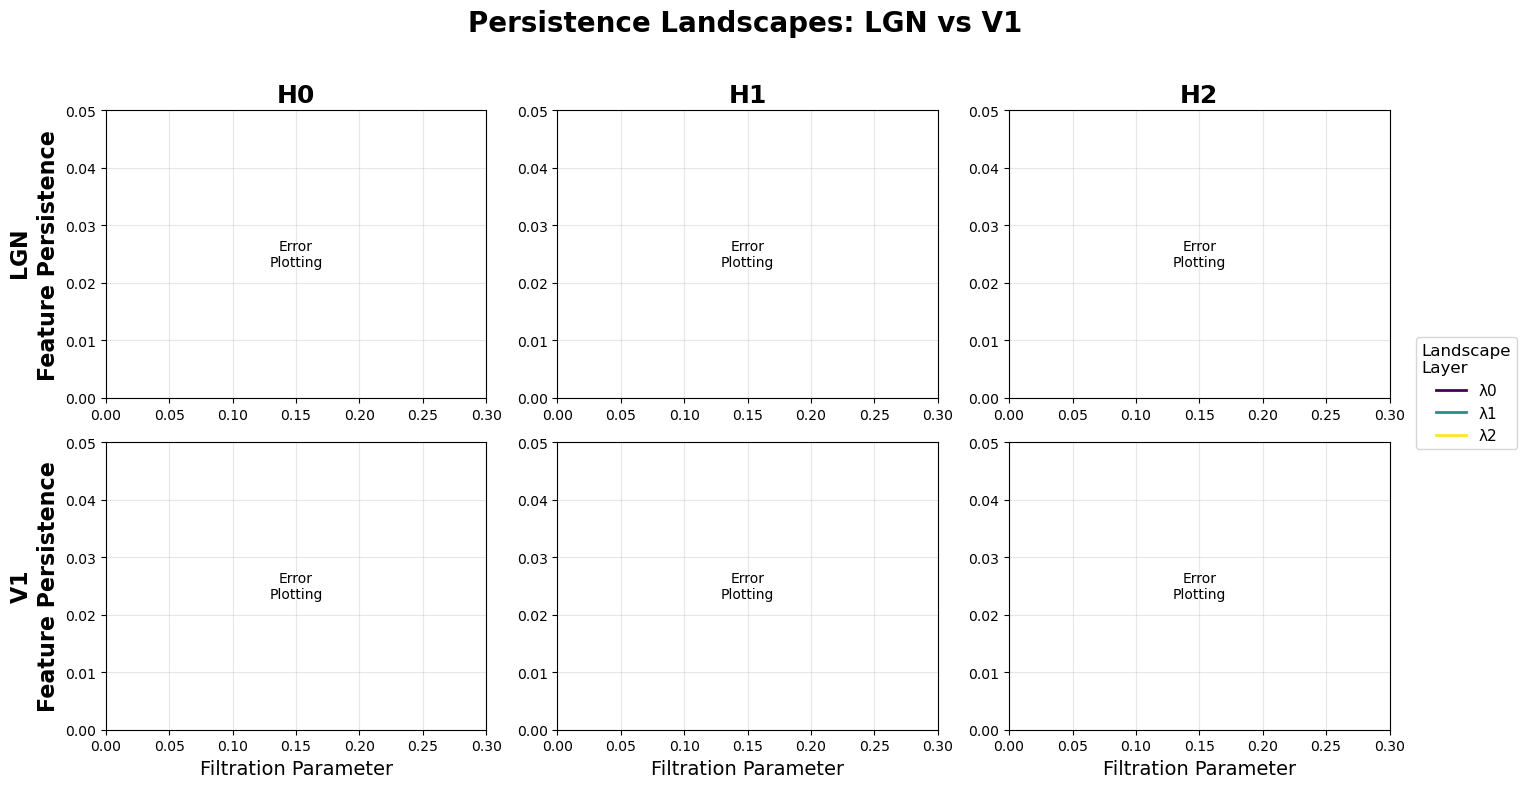


PLOT 2: MULTI-STIMULUS COMPARISONS
🎨 Starting plot_all_stimulus_comparisons...
📊 Creating plot for H0...
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H0.png
✅ H0 plot created successfully!
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H0.png
✅ H0 plot created successfully!


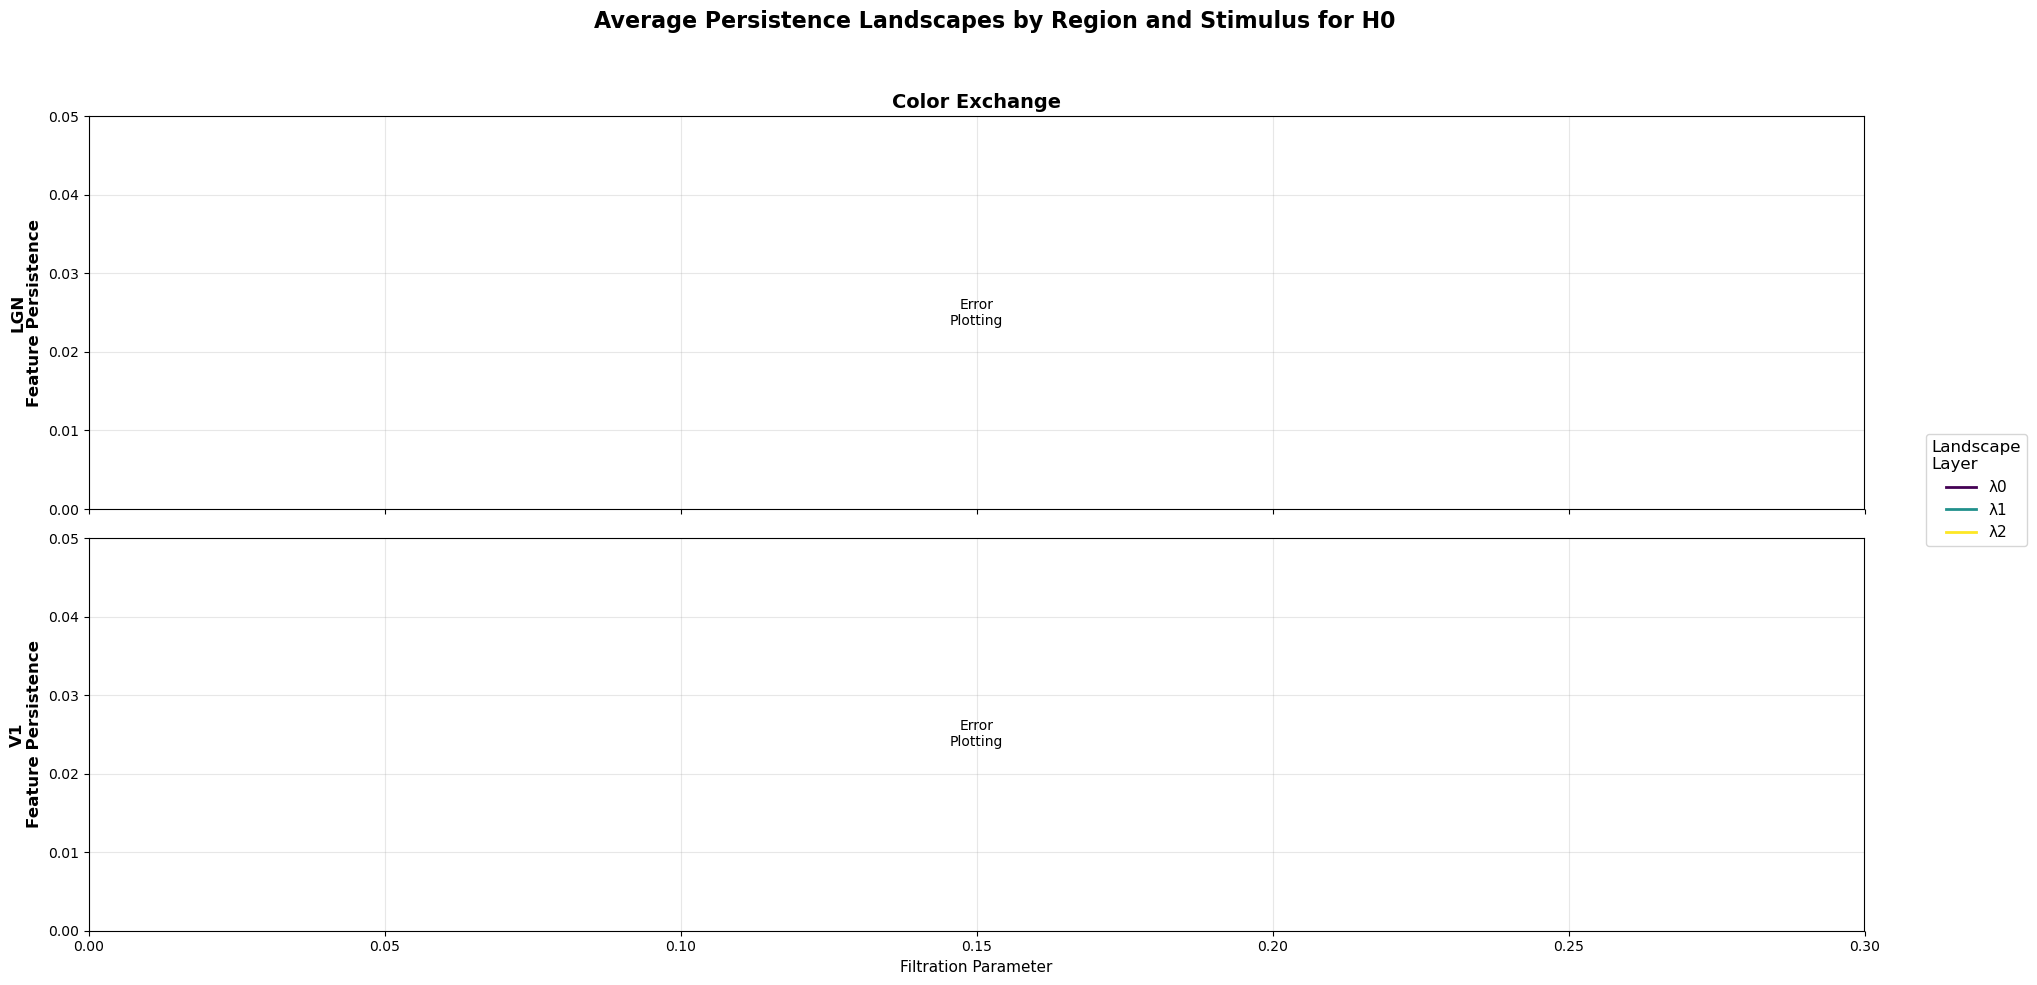

📊 Creating plot for H1...
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H1.png
✅ H1 plot created successfully!
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H1.png
✅ H1 plot created successfully!


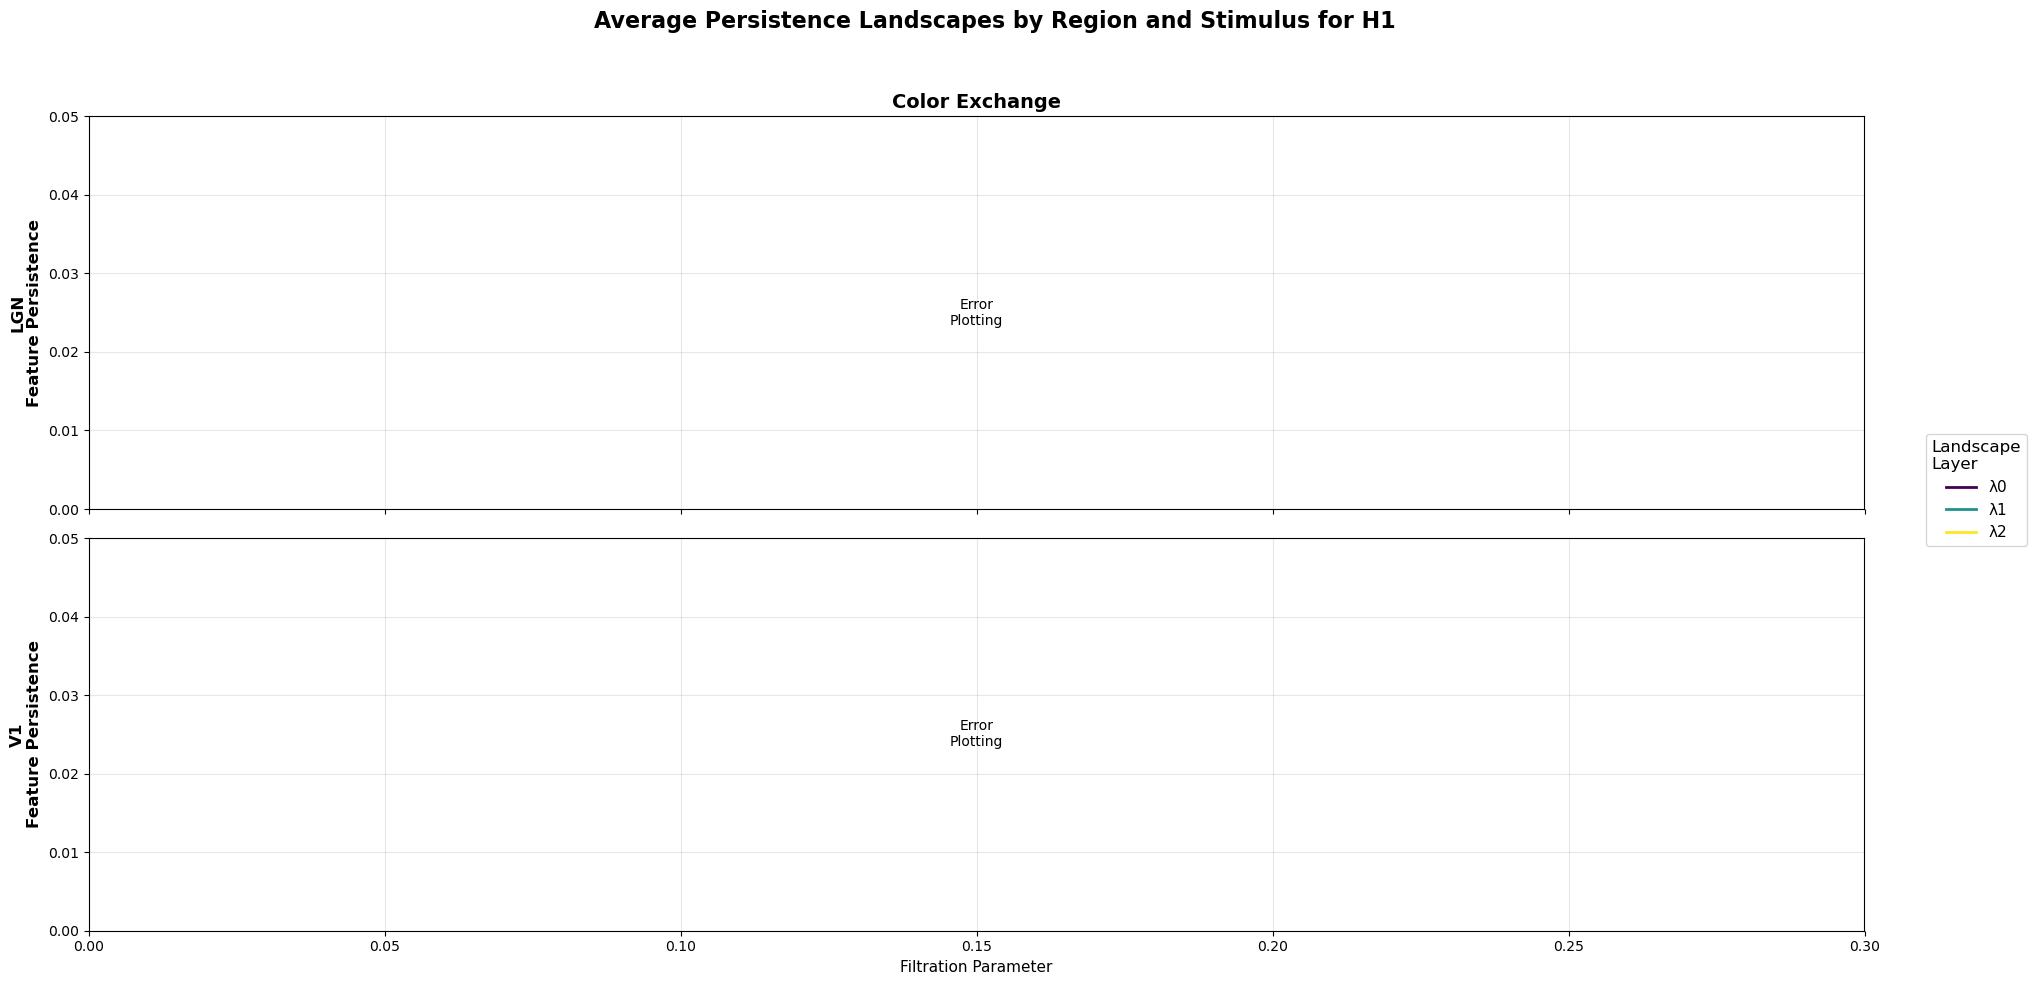

📊 Creating plot for H2...
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H2.png
✅ H2 plot created successfully!
Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/multi_stimulus_landscapes_H2.png
✅ H2 plot created successfully!


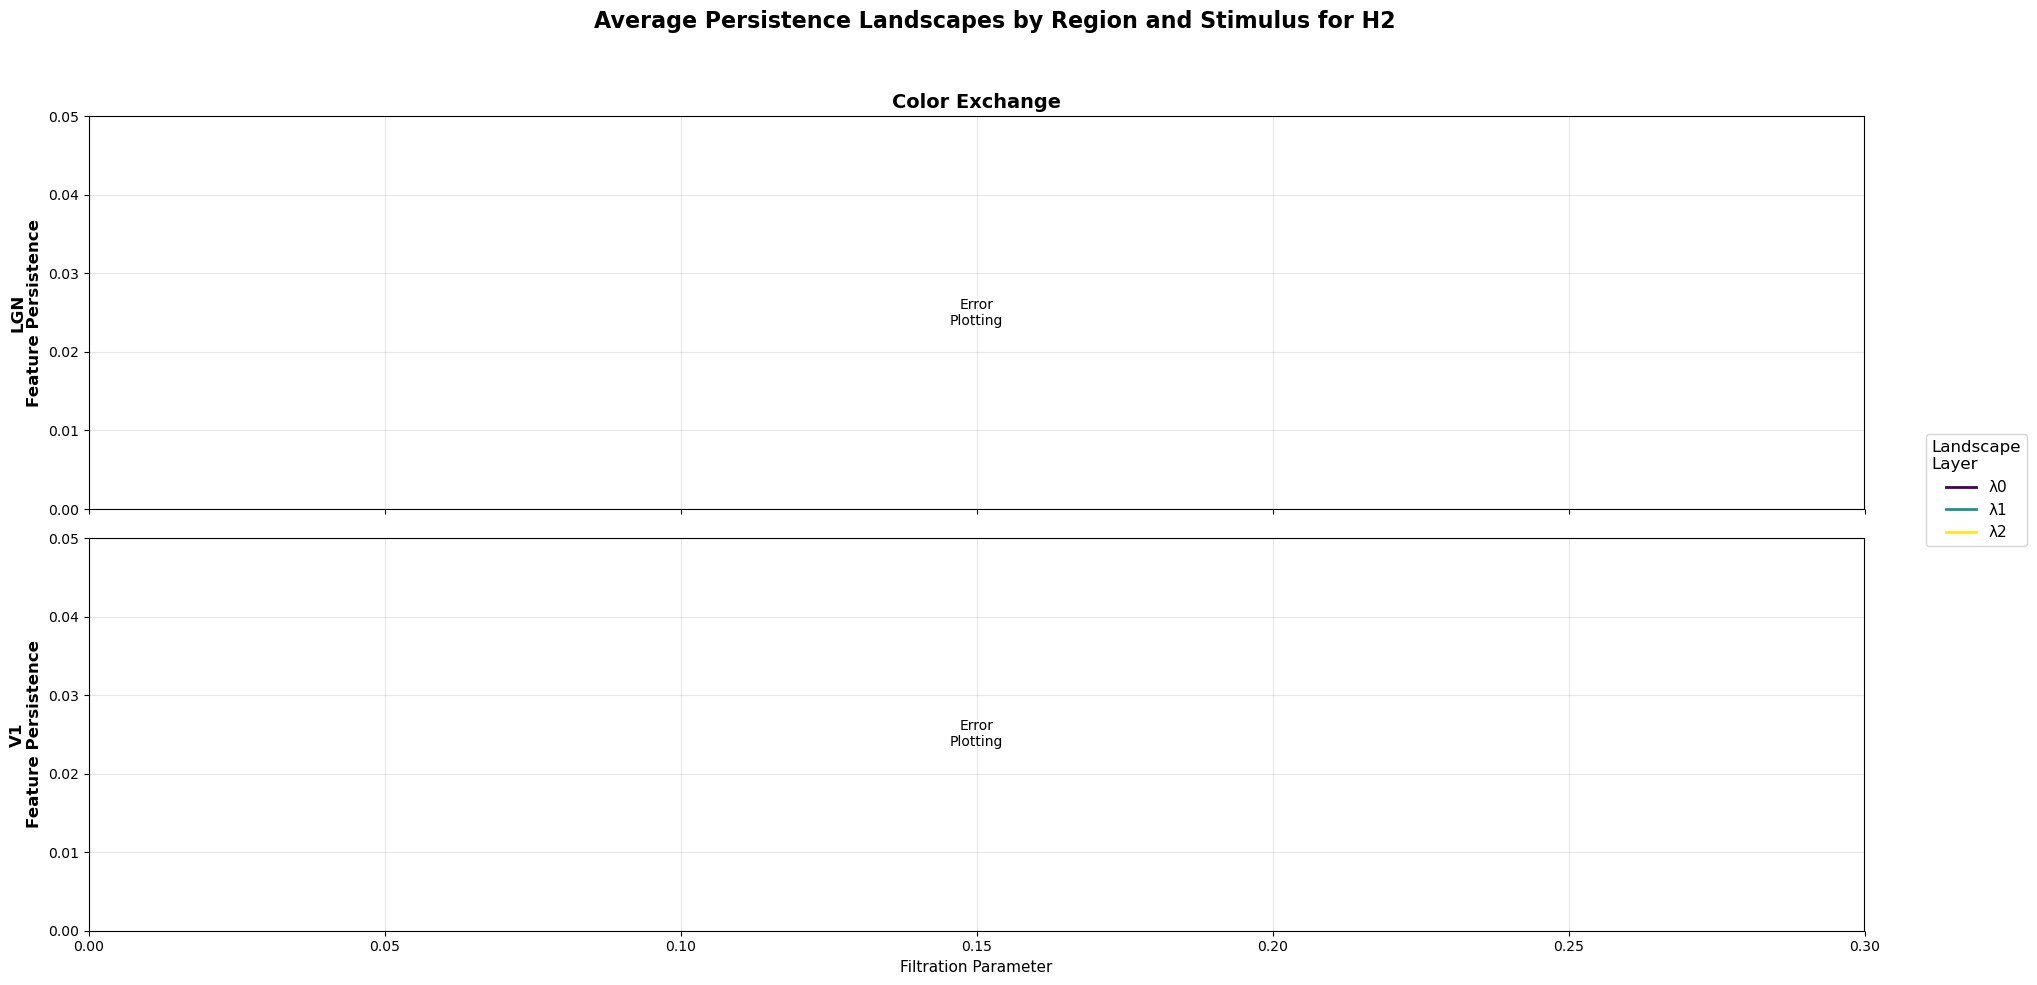

In [53]:
# plotting utils with debugging

# RUN ME

def plot_landscapes_by_region(save_plot=True):
    """Create the standard region x homology plot (LGN/V1 vs H0/H1/H2)."""

    print("🎨 Starting plot_landscapes_by_region...")
    
    if not plotter or not available_files:
        print("❌ No data or plotter available")
        return None
    
    print(f"✅ Plotter available: {plotter is not None}")
    print(f"✅ Available files: {len(available_files)}")
    
    # check for already computed landscapes
    if 'avg_lgn_landscapes' in globals() and 'avg_v1_landscapes' in globals():
        print(f"✅ Found landscape variables:")
        print(f"   LGN landscapes: {list(avg_lgn_landscapes.keys())}")
        print(f"   V1 landscapes: {list(avg_v1_landscapes.keys())}")
        
        landscapes_data = {
            'LGN': avg_lgn_landscapes,
            'V1': avg_v1_landscapes
        }
        
        # Check if landscapes have data
        total_landscapes = 0
        for region, landscapes in landscapes_data.items():
            for hom, landscape in landscapes.items():
                if landscape is not None:
                    total_landscapes += 1
        print(f"   Total non-null landscapes: {total_landscapes}")
        
    else:
        print("❌ Run the landscape computation cell first")
        return None
    
    print("🖼️ Calling plotter.plot_by_region_and_homology...")
    try:
        fig = plotter.plot_by_region_and_homology(
            landscapes_data,
            title="Persistence Landscapes: LGN vs V1",
            figsize=(15, 8),
            save_path="landscapes_by_region.png" if save_plot else None
        )
        
        if fig:
            print("✅ Plot created successfully!")
            plt.show()
        else:
            print("❌ Plot creation returned None")
            
        return fig
        
    except Exception as e:
        print(f"❌ Error creating plot: {e}")
        import traceback
        traceback.print_exc()
        return None


def plot_all_stimulus_comparisons(save_plots=True):
    """Create multi-stimulus plots for all homology groups."""

    print("🎨 Starting plot_all_stimulus_comparisons...")
    
    if not plotter:
        print("❌ No plotter available")
        return []
    
    figures = []
    for hom_deg in range(3):
        print(f"📊 Creating plot for H{hom_deg}...")
        try:
            fig = plotter.plot_multi_stimulus_grid(
                hom_deg=hom_deg,
                figsize=(20, 10),
                save_plots=save_plots
            )
            if fig:
                print(f"✅ H{hom_deg} plot created successfully!")
                plt.show()
                figures.append(fig)
            else:
                print(f"❌ H{hom_deg} plot creation returned None")
        except Exception as e:
            print(f"❌ H{hom_deg} failed with error: {e}")
            import traceback
            traceback.print_exc()
    
    return figures


def plot_custom_comparison(hom_deg=1, stimuli=None, regions=None, save_plot=False):
    """Create custom stimulus/region comparison."""

    print(f"🎨 Starting custom comparison plot for H{hom_deg}...")
    print(f"   Stimuli: {stimuli}")
    print(f"   Regions: {regions}")
    
    if not plotter:
        print("❌ No plotter available")
        return None
    
    try:
        fig = plotter.plot_multi_stimulus_grid(
            hom_deg=hom_deg,
            stimuli=stimuli,
            regions=regions,
            figsize=(16, 8),
            save_plots=save_plot
        )
        
        if fig:
            print("✅ Custom plot created successfully!")
            plt.show()
        else:
            print("❌ Custom plot creation returned None")
            
        return fig
        
    except Exception as e:
        print(f"❌ Custom plot failed with error: {e}")
        import traceback
        traceback.print_exc()
        return None


# Execute main plots with debugging
print("🚀 Starting plot execution...")

if available_files:
    print(f"✅ {len(available_files)} files available for plotting")
    
    # Check if landscapes were computed
    if 'avg_lgn_landscapes' in globals() and 'avg_v1_landscapes' in globals():
        print("✅ Landscape variables found in global scope")
        
        # plot 1 - brain region comparison plot
        print("\n" + "="*50)
        print("PLOT 1: BRAIN REGION COMPARISON")
        print("="*50)
        region_fig = plot_landscapes_by_region()
        
        # plot 2 - multi-stimulus plots for all homology groups  
        print("\n" + "="*50)
        print("PLOT 2: MULTI-STIMULUS COMPARISONS")
        print("="*50)
        stimulus_figs = plot_all_stimulus_comparisons()
        
    else:
        print("❌ Landscape variables not found - run the landscape computation cell first")
    
else:
    print("❌ No data available for plotting")

## Plots

🎨 Starting custom comparison plot for H1...
   Stimuli: ['color_exchange', 'luminance_flash']
   Regions: None
✅ Custom plot created successfully!
✅ Custom plot created successfully!


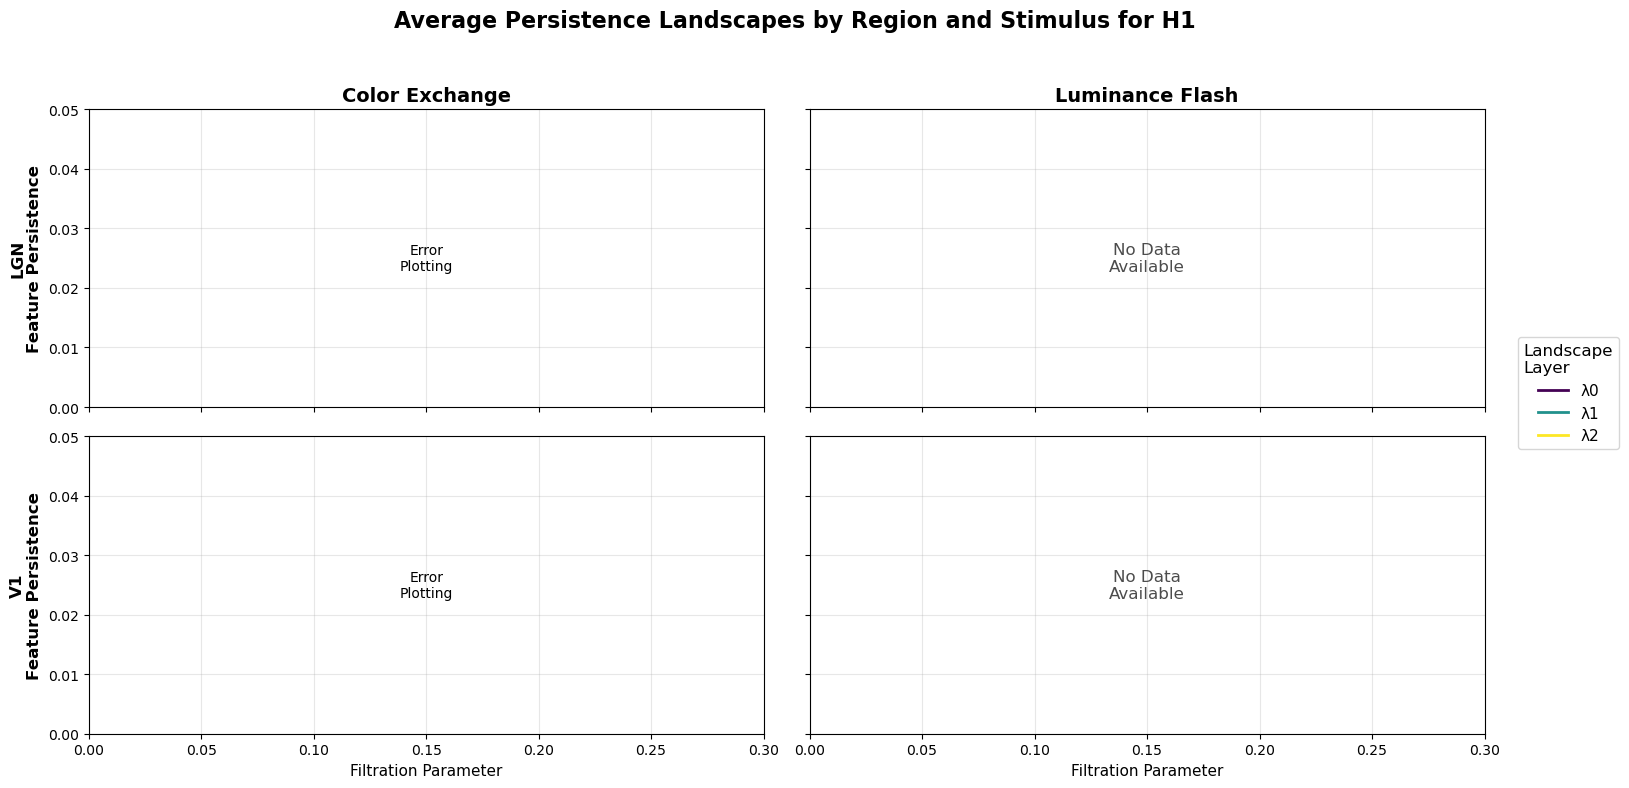

🎨 Starting custom comparison plot for H1...
   Stimuli: None
   Regions: ['V1']
✅ Custom plot created successfully!
✅ Custom plot created successfully!


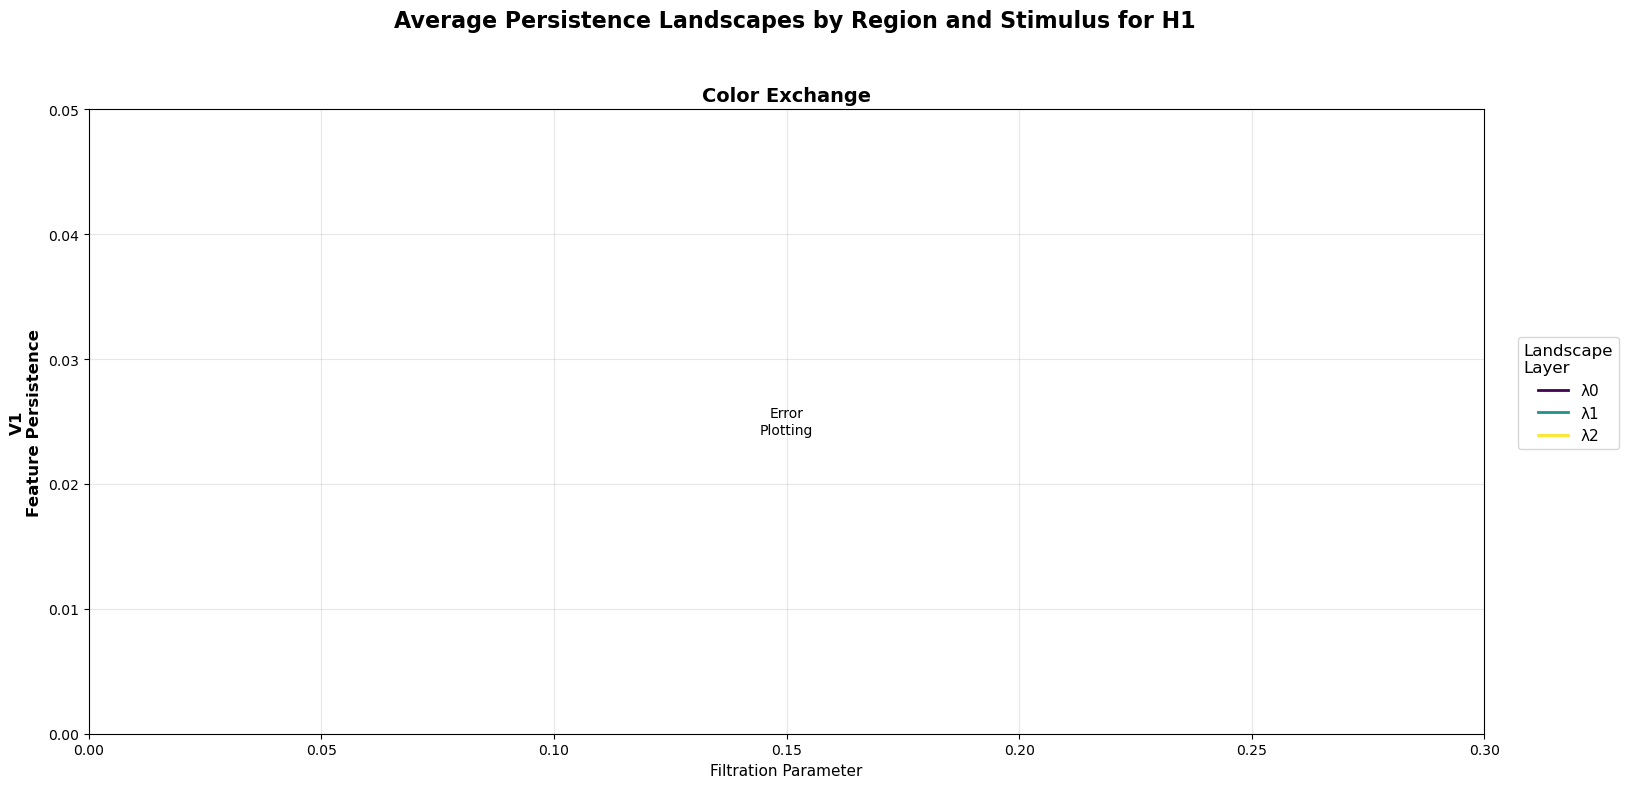

🎨 Starting custom comparison plot for H1...
   Stimuli: ['color_exchange']
   Regions: None
✅ Custom plot created successfully!
✅ Custom plot created successfully!


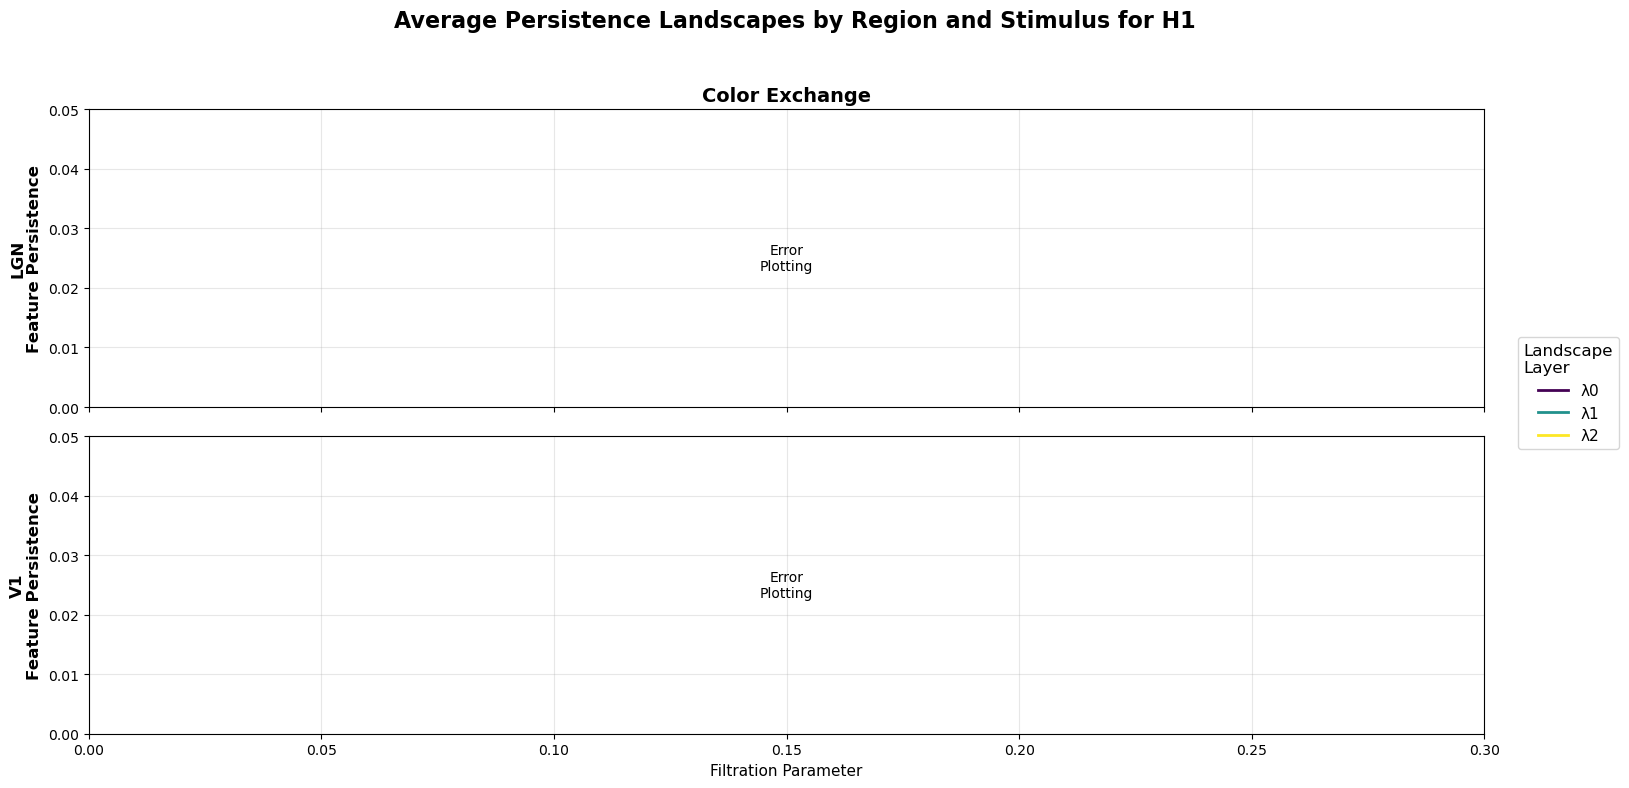

In [50]:
# Other plots

if available_files:
    
    # compare specific stimuli
    one_stim_plot = plot_custom_comparison(
        hom_deg=1,
        stimuli=['color_exchange', 'luminance_flash']
    )
    
    # looking at one brain region
    region_only_plot = plot_custom_comparison(
        hom_deg=1,
        regions=['V1']
    )
    
    # single stimulus across regions
    single_stim_plot = plot_custom_comparison(
        hom_deg=1,
        stimuli=['color_exchange']
    )

else:
    print("No data available for custom plots")